# Homework 04. Evaluation

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from scipy import interpolate
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('bank-full.csv', sep=";")

In [4]:
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


# Data Preparation

In [5]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
           'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
           'previous', 'poutcome', 'y']

In [6]:
df_selected = df[columns]

In [7]:
len(df[columns])

45211

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [9]:
len(df_train)

27126

In [10]:
len(df_val)

9042

In [11]:
len(df_test)

9043

# Question 1

In [12]:
# ROC AUC could also be used to evaluate feature importance of numerical variables.

# Let's do that

# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
# Use the training dataset for that
# If your AUC is < 0.5, invert this variable by putting "-" in front

# (e.g. -df_train['engine_hp'])

# Which numerical variable (among the following 4) has the highest AUC?

In [13]:
numerical = ['age', 'balance', 'day', 'duration']
auc_scores = {}

for var in numerical:
    auc = roc_auc_score(y_train, df_train[var])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
        print(f"Inverted {var} for AUC calculation")
    auc_scores[var] = auc

for var, auc in auc_scores.items():
    print(f"{var}: AUC = {auc:.3f}")

best_var = max(auc_scores, key=auc_scores.get)
print(f"Numerical variable with the highest AUC is: {best_var}")


Inverted age for AUC calculation
Inverted day for AUC calculation
age: AUC = 0.512
balance: AUC = 0.589
day: AUC = 0.526
duration: AUC = 0.815
Numerical variable with the highest AUC is: duration


# Question 2

In [14]:
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# What's the AUC of this model on the validation dataset? (round to 3 digits)

In [17]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:, 1]

auc_val = roc_auc_score(y_val, y_val_pred)

print(f"AUC on validation dataset: {auc_val:.3f}")


AUC on validation dataset: 0.901


# Question 3

In [18]:
# Now let's compute precision and recall for our model.

#Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?



In [19]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == "yes")
        actual_negative = (y_val == "no")

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    #precision = tp / (tp + fp)
    #recall = tp / (tp + fn)
    #precision, recall

    return df_scores

In [20]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [21]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

In [22]:
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

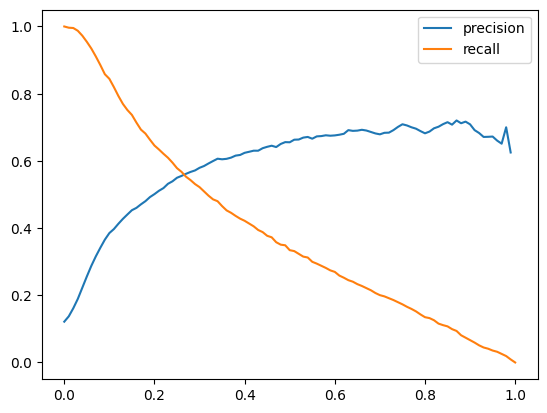

In [23]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.legend()
plt.show()

In [24]:
df_scores['diff'] = np.abs(df_scores.precision - df_scores.recall)
min_diff_index = df_scores['diff'].idxmin()
intersection_threshold = df_scores.loc[min_diff_index, 'threshold']

print(f"Intersection occurs at threshold: {intersection_threshold:.3f}")

Intersection occurs at threshold: 0.270


# Question 4

In [25]:

# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

# At which threshold F1 is maximal?

In [26]:
df_scores['F1'] = 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])

max_f1_threshold = df_scores.loc[df_scores['F1'].idxmax(), 'threshold']
max_f1_value = df_scores['F1'].max()

print(f"Threshold at which F1 is max: {max_f1_threshold:.2f}")
print(f"Max F1 score: {max_f1_value:.3f}")


Threshold at which F1 is max: 0.23
Max F1 score: 0.568


In [27]:
specific_thresholds = [0.02, 0.22, 0.42, 0.62]
for threshold in specific_thresholds:
    f1_at_threshold = df_scores[df_scores['threshold'] == threshold]['F1'].values[0]
    print(f"F1 score at threshold {threshold:.2f}: {f1_at_threshold:.3f}")

F1 score at threshold 0.02: 0.278
F1 score at threshold 0.22: 0.566
F1 score at threshold 0.42: 0.493
F1 score at threshold 0.62: 0.368


# Question 5

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = (df_train_fold['y'] == 'yes').astype(int)
    y_val_fold = (df_val_fold['y'] == 'yes').astype(int)
    
    del df_train_fold['y']
    del df_val_fold['y']
    
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(df_train_fold.to_dict(orient='records'))
    X_val_fold = dv.transform(df_val_fold.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_val_pred_fold)
    
    auc_scores.append(auc_fold)
    
auc_scores = np.array(auc_scores)

std_auc = np.std(auc_scores)

print(f"AUC scores for the folds: {auc_scores}")
print(f"Standard deviation of AUC scores: {std_auc:.6f}")



AUC scores for the folds: [0.89989886 0.90082673 0.91185031 0.90843449 0.91253435]
Standard deviation of AUC scores: 0.005373
